In [1]:
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import MurckoScaffold

df = pd.read_csv('manual-annot.tsv', delimiter='\t')
lib = pd.read_csv('../data/lib/layouts.csv',index_col=0)

lib_mols = [Chem.MolFromSmiles(i) for i in lib['SMILES']]
lib_scaffs = [MurckoScaffold.GetScaffoldForMol(i) for i in lib_mols]
lib_scaff_smiles = [MurckoScaffold.MurckoScaffoldSmiles(i) for i in lib['SMILES']]
print(f"{len(set(lib_scaff_smiles))} unique scaffolds out of {len(lib_mols)}")

616 unique scaffolds out of 978


/home/u0/miniconda3/envs/sxfst/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 252.18it/s]


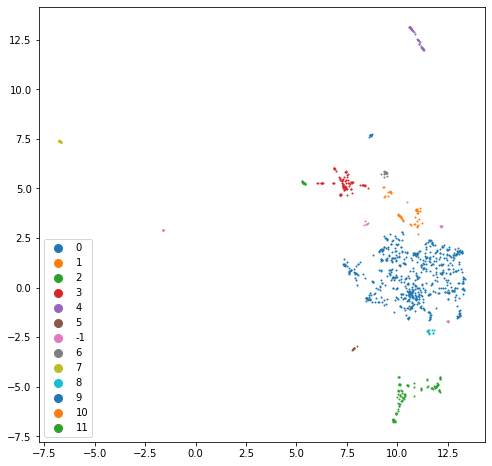

CPU times: user 22.6 s, sys: 219 ms, total: 22.8 s
Wall time: 17.6 s


In [2]:
%%time
from tqdm import tqdm
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN 

fps = np.array([Chem.RDKFingerprint(i) for i in lib_mols])

um = UMAP(metric='manhattan')
xy = um.fit_transform(fps)

dbscan = DBSCAN(eps=0.5,
                min_samples=8,
                n_jobs=-1)
clusters = dbscan.fit_predict(xy)

xyz = pd.DataFrame(xy, columns=list('xy'))
xyz['z'] = clusters

plt.figure(figsize=(8,8))
for i in tqdm(xyz['z'].unique()):
    cl = xyz.loc[xyz['z'] == i, :]
    plt.scatter(cl['x'], 
                cl['y'],
                s=1,
                label=i,
               )
plt.legend(markerscale=8,
           loc='lower left')
plt.show()

In [3]:
from PIL import Image
from io import BytesIO

lib['Cluster'] = clusters
lib['Scaffold'] = lib_scaff_smiles

for i in tqdm(lib['Cluster'].unique()):
    c = lib.loc[lib['Cluster']==i,:]
    if len(c) < 100:
        fig, ax = plt.subplots(len(c),2,
                               figsize=(6,len(c)*3),
                              )
        for ax_row, j, k, l in zip(ax, 
                                   c['SMILES'], 
                                   c['Scaffold'],
                                   c['Item Name']):
            im1 = Draw.MolToImage(Chem.MolFromSmiles(j))
            im2 = Draw.MolToImage(Chem.MolFromSmiles(k))
            ax_row[0].imshow(im1)
            ax_row[1].imshow(im2)
            ax_row[0].axis('off')
            ax_row[1].axis('off')
            ax_row[0].set_title(l)
            ax_row[1].set_title(f'{l} Scaffold')
        fig.suptitle(f'Cluster {i}')
        plt.tight_layout()
        #plt.show()
        plt.close()

100%|███████████████████████████████████████████| 13/13 [00:17<00:00,  1.38s/it]


In [13]:
%%time

df_ = df.copy()[['chemid','smiles']].drop_duplicates()
df_['Scaffold'] = [MurckoScaffold.MurckoScaffoldSmiles(i) for i in df_['smiles']]

cn_in = dict(zip(lib['CatalogNumber'], lib['Item Name']))
df_['Item Name'] = [cn_in[i] for i in df_['chemid']]

for i, j, k, l in tqdm(zip(df_['chemid'],
                           df_['smiles'], 
                           df_['Scaffold'],
                           df_['Item Name'],
                          ),
                       total=len(df_)):
    im1 = Draw.MolToImage(Chem.MolFromSmiles(j))
    im2 = Draw.MolToImage(Chem.MolFromSmiles(k))
    plt.figure(figsize=(6,6))
    plt.imshow(im1)
    plt.axis('off')
    plt.title(l)
    plt.savefig(f'img/hits-{i}.png')
    plt.close()
    
    plt.figure(figsize=(6,6))
    plt.imshow(im2)
    plt.axis('off')
    plt.title(l)
    plt.savefig(f'img/hits-{i}-scaffold.png')
    plt.close()


100%|█████████████████████████████████████████| 822/822 [02:56<00:00,  4.67it/s]

CPU times: user 2min 49s, sys: 7.18 s, total: 2min 56s
Wall time: 2min 56s


In [ ]:
%%time

hits = df.loc[df['hit'], :].copy()
hits['Scaffold'] = [MurckoScaffold.MurckoScaffoldSmiles(i) for i in hits['smiles']]

cn_in = dict(zip(lib['CatalogNumber'], lib['Item Name']))
hits['Item Name'] = [cn_in[i] for i in hits['chemid']]

for i, j, k, l in tqdm(zip(hits['chemid'],
                           hits['smiles'], 
                           hits['Scaffold'],
                           hits['Item Name'],
                          ),
                       total=len(hits)):
    im1 = Draw.MolToImage(Chem.MolFromSmiles(j))
    im2 = Draw.MolToImage(Chem.MolFromSmiles(k))
    plt.figure(figsize=(6,6))
    plt.imshow(im1)
    plt.axis('off')
    plt.title(l)
    plt.savefig(f'img/hits-{i}.png')
    plt.close()
    
    plt.figure(figsize=(6,6))
    plt.imshow(im2)
    plt.axis('off')
    plt.title(l)
    plt.savefig(f'img/hits-{i}-scaffold.png')
    plt.close()

 25%|██████████▍                               | 37/149 [00:07<00:23,  4.81it/s]

In [ ]:
hits['fig'] = [f'![](img/screen/hits-{i}.png)' for i in hits['chemid']]
hits['fig-scaffold'] = [f'![](img/screen/hits-{i}-scaffold.png)' for i in hits['chemid']]
hits_ = hits[['experiment', 'protein',  'chemid',  'Item Name', 'fig', 'fig-scaffold']]
#print(hits_.to_markdown(index=False))

In [ ]:
%%time

hits = df.loc[df['hit'], :].copy()
hits['Scaffold'] = [MurckoScaffold.MurckoScaffoldSmiles(i) for i in hits['smiles']]

cn_in = dict(zip(lib['CatalogNumber'], lib['Item Name']))
hits['Item Name'] = [cn_in[i] for i in hits['chemid']]

fig, ax = plt.subplots(len(hits),2,
                       figsize=(6,len(hits)*3),
                      )
for ax_row, j, k, l in tqdm(zip(ax, 
                           hits['smiles'], 
                           hits['Scaffold'],
                           hits['Item Name']),
                            total=len(hits)):
    im1 = Draw.MolToImage(Chem.MolFromSmiles(j))
    im2 = Draw.MolToImage(Chem.MolFromSmiles(k))
    ax_row[0].imshow(im1)
    ax_row[1].imshow(im2)
    ax_row[0].axis('off')
    ax_row[1].axis('off')
    ax_row[0].set_title(l)
    ax_row[1].set_title(f'{l} Scaffold')
plt.tight_layout()
plt.savefig('img/hits-scaffolds.png')
#plt.show()
plt.close()

In [ ]:
kd_data = pd.read_csv('kds.csv')
kd_data.head()

In [ ]:
#plt.style.use('dark_background')
plt.style.use('default')
for i in kd_data['protein'].unique():
    chunk = kd_data.loc[kd_data['protein']==i,:]
    fig, ax = plt.subplots(2,2, figsize=(8,8))
    for j,k,l in zip(ax.flatten(), 
                     ['km','vmax','rsq'],
                     ['$K_m$', '$V_{max}$', '$R^2$']):
        j.hist(chunk[k],
               bins=64,
               alpha=0.5,
              )
        j.set_title(l)
        j.set_ylabel('Count')
    ax[1,1].axis('off')
    fig.suptitle(f'Michaelis-Menten Metrics for {i}')
    plt.tight_layout()
    plt.savefig(f"img/{i.replace('/','-').replace(' ','-')}-mm-hist.png") 
    plt.show()

In [ ]:
kd_data_ = kd_data.loc[kd_data['rsq']>0,:]
for i in kd_data['protein'].unique():
    chunk = kd_data_.loc[kd_data_['protein']==i,:]
    fig, ax = plt.subplots(2,2, figsize=(8,8))
    for j,k,l in zip(ax.flatten(), 
                     ['km','vmax','rsq'],
                     ['$K_m$', '$V_{max}$', '$R^2$']):
        j.hist(chunk[k],
               bins=32,
               alpha=0.5,
              )
        j.set_title(l)
        j.set_ylabel('Count')
    ax[1,1].axis('off')
    fig.suptitle(f'Michaelis-Menten Metrics for {i}\nWhere $R^2$ > 0')
    plt.tight_layout()
    plt.savefig(f"img/{i.replace('/','-').replace(' ','-')}-mm-hist-gt0.png") 
    plt.show()

In [ ]:
import seaborn as sns
for i in kd_data['protein'].unique():
    chunk = kd_data.loc[kd_data['protein']==i,['km','vmax','rsq']]
    chunk.columns = ['$K_m$', '$V_{max}$', '$R^2$']
    plt.figure(figsize=(8,8))
    sns.pairplot(chunk,
                 kind='kde', )
    plt.suptitle(f'Pairwise-Interactions for Michaelis-Menten Metrics for {i}')
    plt.tight_layout()
    plt.savefig(f"img/{i.replace('/','-').replace(' ','-')}-mm-pairwise.png") 
    plt.show() 

In [ ]:
for i in kd_data['protein'].unique():
    chunk = kd_data_.loc[kd_data_['protein']==i,['km','vmax','rsq']]
    chunk.columns = ['$K_m$', '$V_{max}$', '$R^2$']
    plt.figure(figsize=(8,8))
    sns.pairplot(chunk,
                 kind='kde', )
    plt.suptitle(f'Pairwise-Interactions for Michaelis-Menten Metrics for {i}')
    plt.tight_layout()
    plt.savefig(f"img/{i.replace('/','-').replace(' ','-')}-mm-pairwise-rsqgt0.png") 
    plt.show() 

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(kd_data['vmax'],
            kd_data['km'],
            s=1,
           )
plt.xlabel('$V_{max}$')
plt.ylabel('$K_m$')
plt.title('$K_m$ Against $V_{max}$')
plt.show()

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

fn = lambda x, m, c : (m*x) + c


x = kd_data.loc[kd_data['vmax']<1,:]
(m,c), pos = curve_fit(fn, x['vmax'], x['km'])
r2 = r2_score(x['km'], fn(x['vmax'], m, c))
                       
plt.figure(figsize=(4,4))
plt.scatter(x['vmax'],
            x['km'],
            s=1,
           )
x_ = np.linspace(min(x['vmax']),
                 max(x['vmax']),
                 32)
plt.plot(x_, 
         fn(x_, k,c),
        c='orange',
        lw=2,
        linestyle='--',
        )
plt.text(x=0.2,
         y=300,
         s=f'm = {round(m, 3)}\nc = {round(c,3)}\n$R^2$ = {round(r2,2)}'
        )
plt.xlabel('$V_{max}$')
plt.ylabel('$K_m$')
plt.title('$K_m$ Against $V_{max}$ Where $V_{max}$ < 1')
plt.savefig('img/km-vs-vmax-corr.png')
plt.show()

In [ ]:
kms.head()

In [ ]:
'ss'.capitalize()

In [ ]:
kms = df.loc[df['rsq']>0,:]
kms = kms.loc[kms['vmax']<3,:]

kms['Compond Structure'] = [f'![](img/screen/hits-{i}.png)' for i in kms['cpd']]
kms['Compound Scaffold'] = [f'![](img/screen/hits-{i}-scaffold.png)' for i in kms['cpd']]
kms.columns = [i.capitalize() for i in kms.columns]
print(kms.to_markdown(index=False))